# Explorative Datenanalyse [Viertelstündliche Prognose des PV-Überschusses]

## 1.) Ziel der Analyse
### Forschungsfrage:
In welchem Maße können Machine-Learning-Modelle den viertelstündlichen PV-Überschuss einer Photovoltaikanlage unter Nutzung von Wetter-, Einstrahlungs- und historischen Verbrauchsdaten vorhersagen?
### Hypothesen:
1. Hohe solare Einstrahlung führt nicht zwangsläufig zu einem hohen PV-Überschuss, da zeitgleich erhöhter Stromverbrauch den Überschuss reduziert. 
2. Modelle mit Wetter- und Einstrahlungsdaten prognostizieren den viertelstündlichen PV-Überschuss genauer als naive Prognosemethoden (z. B. „letzter gemessener Wert“ oder historischer Durchschnitt). 
3. Die Berücksichtigung zeitlicher Merkmale wie Uhrzeit und Wochentag verbessert die Prognose des viertelstündlichen PV-Überschusses. 
4. Nichtlineare Machine-Learning-Modelle sind besser geeignet zur Prognose des viertelstündlichen PV-Überschusses als lineare Regressionsmodelle.

## 2.) Definition Zielvariable
**PV-Überschuss:** PV-Überschuss = Solarproduktion − Σ(Verbrauch)

## 3.) Daten laden und vorbereiten

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PV-Daten
pv = pd.read_csv("data/pv_data.csv", sep=";")
pv["timestamp"] = pd.to_datetime(pv["timestamp"])

# Wetterdaten
weather = pd.read_csv("data/weather.csv")
weather["time"] = pd.to_datetime(weather["time"])

# Merge auf Zeitstempel
df = pd.merge(pv, weather, left_on="timestamp", right_on="time", how="inner")

df.set_index("timestamp", inplace=True)

#Definition Zielvariable
df["PV_Ueberschuss"] = df["Solarproduktion"] - df["Σ Verbrauch"]
df["PV_Ueberschuss"] = df["PV_Ueberschuss"].clip(lower=0)


## 4.) Zeitumfang der Daten

Erwartung:
- 96 Werte pro Tag
- Prüfung auf fehlende Zeitpunkte

In [5]:
start = df.index.min()
end = df.index.max()
dauer = end - start

print("Zeitraum:", start, "bis", end)
print("Gesamtdauer:", dauer)
print("Anzahl Viertelstunden:", len(df))

df.resample("15min").size()

Zeitraum: 2022-02-07 14:00:00 bis 2025-06-16 23:00:00
Gesamtdauer: 1225 days 09:00:00
Anzahl Viertelstunden: 28474


timestamp
2022-02-07 14:00:00    1
2022-02-07 14:15:00    0
2022-02-07 14:30:00    0
2022-02-07 14:45:00    0
2022-02-07 15:00:00    1
                      ..
2025-06-16 22:00:00    1
2025-06-16 22:15:00    0
2025-06-16 22:30:00    0
2025-06-16 22:45:00    0
2025-06-16 23:00:00    1
Freq: 15min, Length: 117637, dtype: int64

## 5) Deskriptive Statistik der Hauptkategorien
Analyse von:
- Solarproduktion
- Wallbox Gesamtladeleistung
- Wallbox Solarladeleistung
- PV-Überschuss

In [6]:
kategorien = [
    "Solarproduktion",
    "Wallbox Gesamtladeleistung",
    "Wallbox (ID 0) Solarladeleistung",
    "PV_Ueberschuss"
]

df[kategorien].describe()

#zusätzl. explizit:
for col in kategorien:
    print(f"\n--- {col} ---")
    print("Mittelwert:", df[col].mean())
    print("Minimum:", df[col].min())
    print("Maximum:", df[col].max())



--- Solarproduktion ---
Mittelwert: 328.7865421085903
Minimum: 0
Maximum: 2339

--- Wallbox Gesamtladeleistung ---
Mittelwert: 33.26344666695468
Minimum: 0.0
Maximum: 2775.0

--- Wallbox (ID 0) Solarladeleistung ---
Mittelwert: 21.648939387393614
Minimum: 0.0
Maximum: 2711.0

--- PV_Ueberschuss ---
Mittelwert: 244.12643113015383
Minimum: 0
Maximum: 2145


## 6) Zeitliche Muster analysieren
### 6.1) Tagesgang der Solarproduktion
Erwartung: Glockenkurve mit Maximum mittags

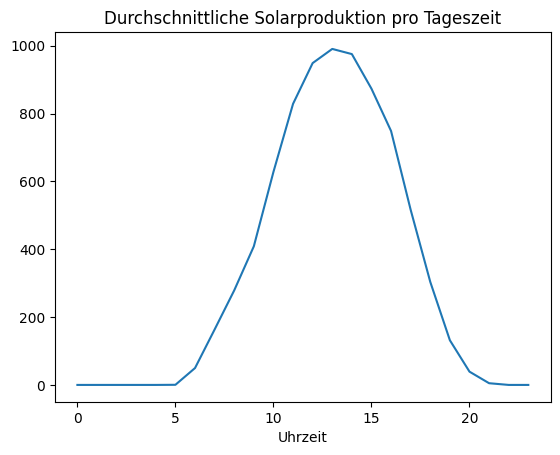

In [7]:
df["Uhrzeit"] = df.index.hour + df.index.minute/60

plt.figure()
df.groupby("Uhrzeit")["Solarproduktion"].mean().plot()
plt.title("Durchschnittliche Solarproduktion pro Tageszeit")
plt.show()


### 6.2) PV-Überschuss im Tagesverlauf
Hypothese 3 relevant:
→ Zeitliche Features scheinen wichtig.

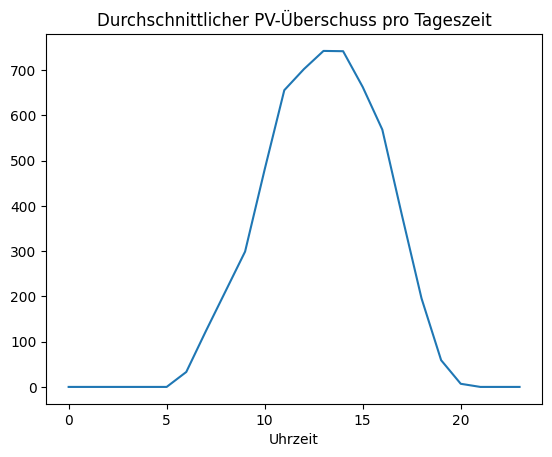

In [8]:
plt.figure()
df.groupby("Uhrzeit")["PV_Ueberschuss"].mean().plot()
plt.title("Durchschnittlicher PV-Überschuss pro Tageszeit")
plt.show()


### 6.3) Wochentagseffekt


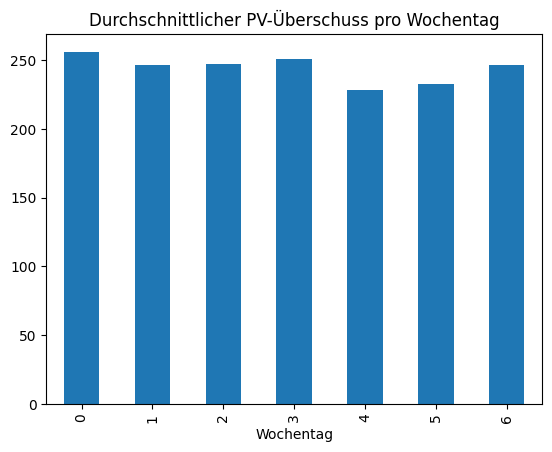

In [9]:
df["Wochentag"] = df.index.dayofweek

plt.figure()
df.groupby("Wochentag")["PV_Ueberschuss"].mean().plot(kind="bar")
plt.title("Durchschnittlicher PV-Überschuss pro Wochentag")
plt.show()


## 7) Zusammenhang Wetter <-> PV-Überschuss
### 7.1) Korrelation
Wichtig:
- cloud_cover
- temperature
- precipitation
- wind_speed

In [10]:
korrelationen = df.corr(numeric_only=True)["PV_Ueberschuss"].sort_values(ascending=False)
korrelationen.head(15)


PV_Ueberschuss               1.000000
Solarproduktion              0.950789
Solarproduktion Tracker 2    0.902958
Netzeinspeisung              0.853348
Solarproduktion Tracker 1    0.755363
Ladezustand                  0.467946
temperature_2m (°C)          0.464298
Batterie (Laden)             0.424261
wind_gusts_10m (km/h)        0.142738
Uhrzeit                      0.121505
pressure_msl (hPa)           0.049742
Hausverbrauch                0.036621
wind_speed_10m (km/h)        0.012131
Wochentag                   -0.012556
Σ Verbrauch                 -0.034601
Name: PV_Ueberschuss, dtype: float64

### 7.2) Einstrahlung vs. Überschuss
Falls direkte Einstrahlungsdaten fehlen → cloud_cover als Proxy.

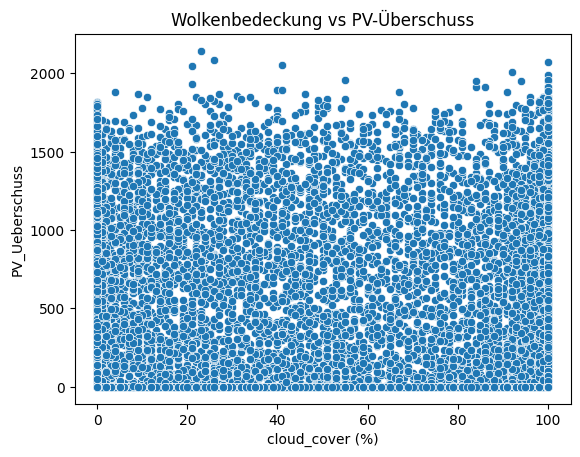

In [11]:
plt.figure()
sns.scatterplot(x=df["cloud_cover (%)"], y=df["PV_Ueberschuss"])
plt.title("Wolkenbedeckung vs PV-Überschuss")
plt.show()


## 8) Analyse zur Hypothese 1
**Hohe Einstrahlung führt nicht zwangsläufig zu hohem Überschuss.**
Wenn viele Punkte:
- hohe Solarproduktion
- aber niedriger Überschuss

→ Hypothese 1 bestätigt (Verbrauch kompensiert Produktion).

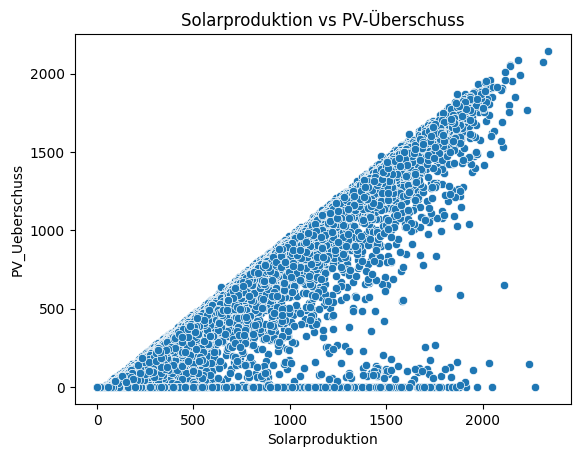

<Axes: xlabel='Σ Verbrauch', ylabel='PV_Ueberschuss'>

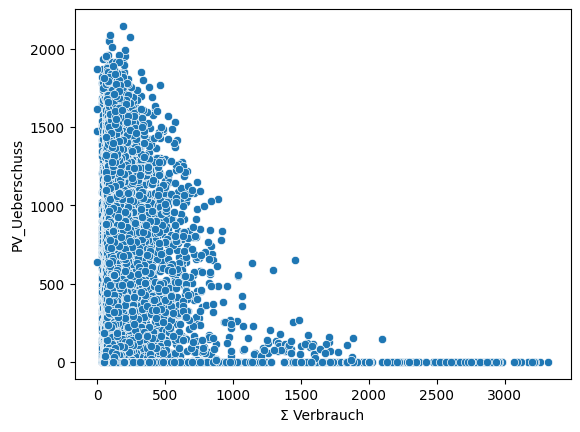

In [13]:
plt.figure()
sns.scatterplot(x=df["Solarproduktion"], y=df["PV_Ueberschuss"])
plt.title("Solarproduktion vs PV-Überschuss")
plt.show()

#zusätzl.:
sns.scatterplot(x=df["Σ Verbrauch"], y=df["PV_Ueberschuss"])


## 9) Vergleich mit naiver Prognose (Baseline)
Naive Methode: Ý​t​ = Yt−1​

Diese Zahl dient später als Referenz für ML-Modelle (Hypothese 2).

In [15]:
df["Naive_Pred"] = df["PV_Ueberschuss"].shift(1)

from sklearn.metrics import mean_absolute_error

mae_naive = mean_absolute_error(
    df["PV_Ueberschuss"][1:],
    df["Naive_Pred"][1:]
)

print("Naive MAE:", mae_naive)


Naive MAE: 123.70231447336073


## 10) Nichtlinearität prüfen (Hypothese 4)
Wenn:
- gekrümmte Muster
- Sättigungseffekte

→ spricht für nichtlineare Modelle (Random Forest, XGBoost).

<Axes: xlabel='temperature_2m (°C)', ylabel='PV_Ueberschuss'>

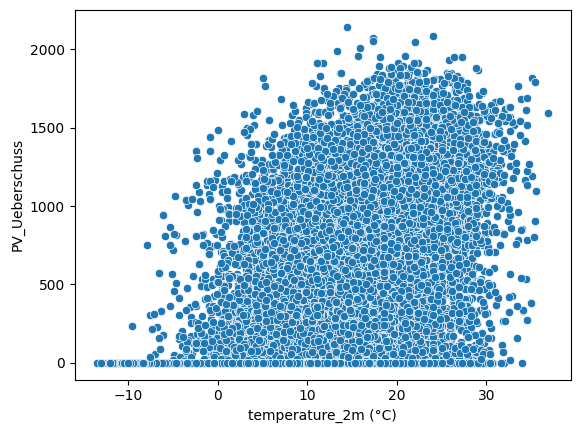

In [16]:
sns.scatterplot(
    x=df["temperature_2m (°C)"],
    y=df["PV_Ueberschuss"]
)


## 11) Verteilung der Zielvariable
Typisch:
- viele Nullwerte (nachts)
- rechtsschiefe Verteilung

Wichtig für Modellwahl!

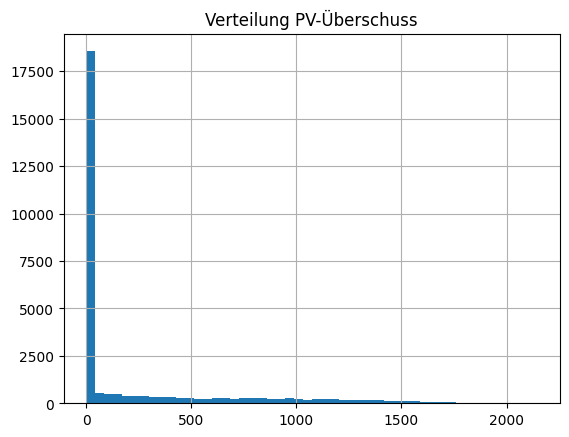

In [17]:
plt.figure()
df["PV_Ueberschuss"].hist(bins=50)
plt.title("Verteilung PV-Überschuss")
plt.show()


## 12) Feature Engineering vorbereiten
Für spätere ML-Modelle:

(Diese Features testen Hypothese 3.)

In [19]:
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month

df["lag_1"] = df["PV_Ueberschuss"].shift(1)
df["lag_4"] = df["PV_Ueberschuss"].shift(4)
df["rolling_mean_4"] = df["PV_Ueberschuss"].rolling(4).mean()


## Erwartete EDA-Erkenntnisse
|Hypothese | Erwartete EDA-Unterstützung |
|----------|------------------------------|
|1	|Korrelation Solarproduktion ↔ Überschuss < 1|
|2	|Naive MAE relativ hoch|
|3	|Starke Tageszeit- und Wochentagseffekte|
|4	|Nichtlineare Scatterplots|

## Verbindung zur Forschungsfrage

Die EDA zeigt:
- Wie stark Wetterfaktoren Einfluss haben
- Wie stark Verbrauch den Überschuss reduziert
- Ob starke zeitliche Muster existieren
- Ob Nichtlinearität vorhanden ist

Diese Erkenntnisse bestimmen:
- Feature-Auswahl
- Modellwahl
- Erwartete Modellgüte